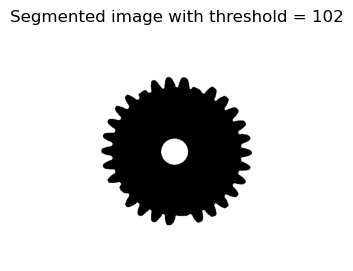

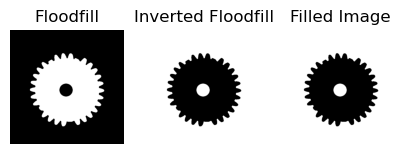

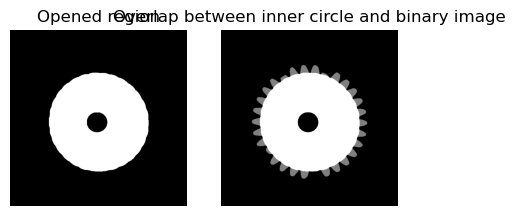

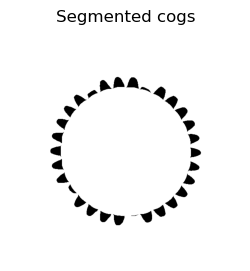

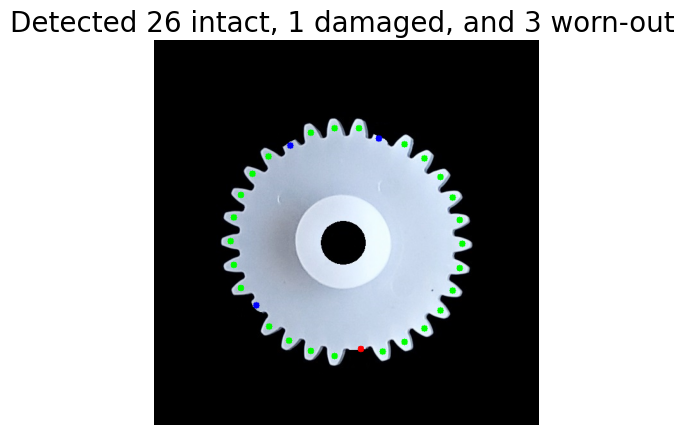

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def imshow(img):



  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis("off")

# Image file name
img_path = "sample3.jpg"
img = cv2.imread(img_path)


# Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Filter out remaining pixels
gray = cv2.medianBlur(gray, 5)

# Binarize grayscale image with Otsu's method for automatic image thresholding
(thres, bw) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

inverted_bw = cv2.bitwise_not(bw)
# Display segmented image
plt.figure(figsize = (3, 3))
imshow(inverted_bw)
plt.title(f"Segmented image with threshold = {int(thres)}")
plt.show()
     

floodfill = bw.copy()

# Mask used to flood filling
# Its sizes must be 2 pixels larger than the image
h, w = bw.shape[:2]
mask = np.zeros((h + 2, w + 2), np.uint8)

# Flood fill from point (0, 0), i.e. background
cv2.floodFill(floodfill, mask, (0,0), 0);

# Invert flood filled image
floodfill_inv = cv2.bitwise_not(floodfill)

# Combine the two images to get the foreground.
fill = floodfill_inv & inverted_bw


# Display images
plt.figure(figsize = (5, 4))

ax = plt.subplot(1, 3, 1)
imshow(floodfill)
plt.title("Floodfill")

ax = plt.subplot(1, 3, 2)
imshow(floodfill_inv)
plt.title("Inverted Floodfill")

ax = plt.subplot(1, 3, 3)
imshow(fill)
plt.title("Filled Image")

plt.show()



# Invert image colors for opening to work
fill = cv2.bitwise_not(floodfill_inv)
# Kernel size is (100. 100), determined empirically
kernel = cv2.getStructuringElement(shape = cv2.MORPH_ELLIPSE, ksize = (100,100))
# Open region
open = cv2.morphologyEx(fill, cv2.MORPH_OPEN, kernel)

# Display images
plt.figure(figsize = (5, 4))
plt.subplot(1, 2, 1)
imshow(open)
plt.title("Opened region")

plt.subplot(1, 2, 2)
overlap = cv2.addWeighted(fill, 0.5, open, 0.5, 0.0)
imshow(overlap)
plt.title("Overlap between inner circle and binary image")
plt.show()
     



img_cogs = open | inverted_bw

# Display segmented cogs
plt.figure(figsize = (3, 3))
imshow(img_cogs)
plt.title("Segmented cogs")
plt.show()

# Invert image colors for conected component detection to work
img_cogs = cv2.bitwise_not(img_cogs)
# Detect connected components
count, labels, stats, centroids = cv2.connectedComponentsWithStats(img_cogs)
# List containing the area of each connected component found
areas = stats[:,4]
# Median of areas, considering there are more cogs than defects (missing cogs)
median = np.median(areas)


# Show detected cogs
img_centroids = img.copy()

cog_count = 0
damaged_cog_count = 0
worn_out_cog_count = 0

for i in range(1, count):  # Start from 1 to skip the background component
    area = areas[i]
    
    # Criteria for intact teeth
    if median - 81 < area < median + 140:
        cv2.circle(img_centroids, (int(centroids[i, 0]), int(centroids[i, 1])), 5, (0, 255, 0), -1)
        cog_count += 1

    # Criteria for worn-out teeth (near the lower threshold)
    elif median - 420 <= area < median - 81:  # Adjust threshold based on observation
        cv2.circle(img_centroids, (int(centroids[i, 0]), int(centroids[i, 1])), 5, (255, 0, 0), -1)
        worn_out_cog_count += 1

    # Criteria for damaged teeth (too small)
    elif 1 < area < median - 300:
        cv2.circle(img_centroids, (int(centroids[i, 0]), int(centroids[i, 1])), 5, (0, 0, 255), -1)
        damaged_cog_count += 1

if cog_count + worn_out_cog_count + damaged_cog_count != 30 : #the total number of teeth in the ideal image

    damaged_cog_count = 30- (cog_count + worn_out_cog_count)


plt.figure(figsize=(5, 5))
imshow(img_centroids)
plt.title(f"Detected {cog_count} intact, {damaged_cog_count} damaged, and {worn_out_cog_count} worn-out ", fontsize=20)
plt.show()